# Download datasets

In [1]:
!mkdir data
!wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P ./data/
!wget http://images.cocodataset.org/zips/train2014.zip -P ./data/
!wget http://images.cocodataset.org/zips/val2014.zip -P ./data/

--2022-09-19 16:08:03--  http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip
Resolving msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)... 20.60.195.163
Connecting to msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)|20.60.195.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19673183 (19M) [application/octet-stream Charset=UTF-8]
Saving to: ‘./data/captions_train-val2014.zip’

captions_train-val2 100%[===================>]  18.76M  16.1MB/s    in 1.2s    

2022-09-19 16:08:04 (16.1 MB/s) - ‘./data/captions_train-val2014.zip’ saved [19673183/19673183]

--2022-09-19 16:08:04--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.20.154
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.20.154|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘./data/train2014.zi

In [2]:
%%bash
unzip ./data/captions_train-val2014.zip -d ./data/
rm ./data/captions_train-val2014.zip
unzip ./data/train2014.zip -d ./data/
rm ./data/train2014.zip 
unzip ./data/val2014.zip -d ./data/ 
rm ./data/val2014.zip 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#Installation of Pycocotools

In [ ]:
%%bash
git clone https://github.com/pdollar/coco.git
cd coco/PythonAPI/
make
sudo python setup.py build
sudo python setup.py install

#Load packages

In [3]:
import torch
from torch.utils.data import Dataset 
from torchvision.transforms import transforms
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F

import json
import os
import math
import time
import cv2

from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

from rnn_lstm_attention_captioning import *
from a4_helper import *

from eecs598.utils import reset_seed, tensor_to_image, decode_captions, attention_visualizer
from eecs598.grad import rel_error, compute_numeric_gradient

import nltk
nltk.download('popular')
nltk.download('punkt')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [4]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

Good to go!


# Building the dataset

In [86]:
# https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/image_captioning/data_loader.py
class CocoDataset(Dataset):
  def __init__(self, images_path, captions_path, token_to_idx, captions_length, transform=None):
    self.images_path = images_path
    self.tranform = transform
    self.coco = COCO(captions_path)
    self.ids = list(self.coco.anns.keys())
    self.token_to_idx = token_to_idx
    self.captions_length = captions_length

  def __getitem__(self, index):
    """ Returns image and its captions """
    ann_idx = self.ids[index]
    annotation = self.coco.anns[ann_idx]["caption"]
    image_id = self.coco.anns[ann_idx]["image_id"]
    image_path = self.coco.loadImgs(image_id)[0]["file_name"]
    
    image = Image.open(os.path.join(self.images_path, image_path)).convert("RGB")
    if self.tranform is not None:
      image = self.tranform(image)
      image = (255 * image).to(torch.uint8)
    
    tokens = nltk.tokenize.word_tokenize(str(annotation).lower())
    caption = [self.token_to_idx.get(token, 3) for token in tokens]

    target = [self.token_to_idx['<START>']] + \
              caption[:self.captions_length] + \
              [self.token_to_idx['<END>']]
    caps_left = self.captions_length + 2 - len(target)
    target = target + caps_left * [0]

    target = torch.Tensor(target)
    return image, target

  def __len__(self):
    #####################################################
    ###  Remove the [:10000] to use the whole dataset ###
    #####################################################
    return len(self.ids[:10000])


def collate_fn(data):
  """Create mini batch tensor from list tuple (image, caption)
  Input:
    data: list of tuple (image, caption)
    image of shape (3, 112, 112)
    caption of shape (?)
  Returns:
    images: torch tensor of shape (batch_size, 3, 112, 112)
    targets: torch tensor of shape (batch_size, padded_length)
  """
  images, captions = zip(*data)
  images = torch.stack(images, 0).to(**to_long)
  targets = torch.stack(captions, 0).to(**to_long)
  return images, targets 


def build_vocabulary(captions_path, threshold=4):
  dataset = json.load(open(captions_path, 'r'))
  anns = dataset["annotations"]
  counter = Counter()
  for id in range(len(anns)):
    cap = anns[id]["caption"]
    tokens = nltk.tokenize.word_tokenize(cap.lower())
    counter.update(tokens)
  
  words = [word for word, cnt in counter.items() if cnt >= threshold]
  idx_to_token = ['<NULL>', '<START>', '<END>', '<UNK>'] + words
  token_to_idx = {token: i for i, token in enumerate(idx_to_token)}
  return idx_to_token, token_to_idx

##Vocabulary

In [6]:
idx_to_token, token_to_idx = build_vocabulary("./data/annotations/captions_train2014.json")

##Dataset

In [87]:
transform = transforms.Compose([ 
        transforms.Resize((112, 112)),
        transforms.ToTensor()])

# transforms.Normalize((0.485, 0.456, 0.406), 
#                      (0.229, 0.224, 0.225))

T = 15
# Load train and validation data
coco_dataset_train = CocoDataset("./data/train2014/", 
            "./data/annotations/captions_train2014.json", 
            token_to_idx, T,
            transform)

coco_dataset_validation = CocoDataset("./data/val2014/", 
            "./data/annotations/captions_val2014.json", 
            token_to_idx, T,
            transform)

num_train = len(coco_dataset_train)
num_val   = len(coco_dataset_validation)

# Declare variables for special tokens
NULL_index  = token_to_idx['<NULL>']
START_index = token_to_idx['<START>']
END_index   = token_to_idx['<END>']
UNK_index   = token_to_idx['<UNK>']

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


#Train

In [90]:
def captioning_train(rnn_model, data_loader_train, lr_decay=1, **kwargs):
  """
  Run optimization to train the model.
  """
  # optimizer setup
  from torch import optim
  optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, rnn_model.parameters()),
    learning_rate) # leave betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,
                                             lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  loss_history = []
  rnn_model.train()
  for i in range(num_epochs):
    start_t = time.time()
    for j, (images, captions) in enumerate(data_loader_train):
      loss = rnn_model(images.to(**to_long_cuda), captions.to(**to_long_cuda))
      optimizer.zero_grad()
      loss.backward()
      loss_history.append(loss.item())
      optimizer.step()
    end_t = time.time()
    print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(
        i, num_epochs, loss.item(), end_t-start_t))

    lr_scheduler.step()

  # plot the training losses
  plt.plot(loss_history)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.show()
  return rnn_model, loss_history

#Vanilla RNN

##Training the model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


learning rate is:  0.001
(Epoch 0 / 5) loss: 56.4397 time per epoch: 98.5s
(Epoch 1 / 5) loss: 49.9854 time per epoch: 96.3s
(Epoch 2 / 5) loss: 43.5156 time per epoch: 94.6s
(Epoch 3 / 5) loss: 42.7453 time per epoch: 99.1s
(Epoch 4 / 5) loss: 42.2590 time per epoch: 97.7s


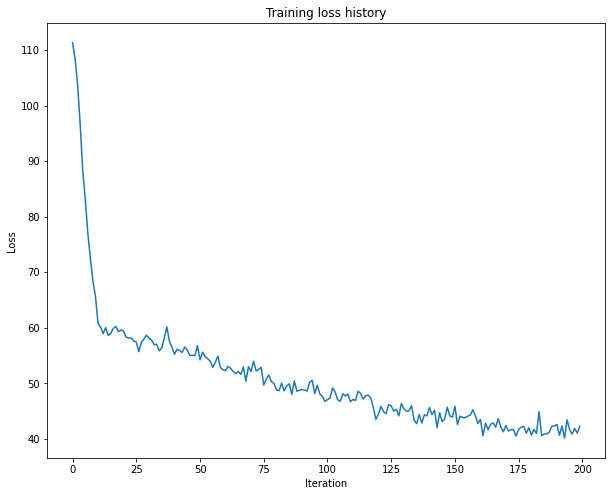

In [91]:
reset_seed(0)

# data input
small_num_train = num_train
batch_size = 250
shuffle = True

data_loader_train = torch.utils.data.DataLoader(dataset=coco_dataset_train, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              collate_fn=collate_fn)
# optimization arguments
num_epochs = 5

# create the image captioning model
rnn_model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=token_to_idx,
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  rnn_model_submit, rnn_loss_submit = captioning_train(rnn_model, data_loader_train,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

##Testing the model

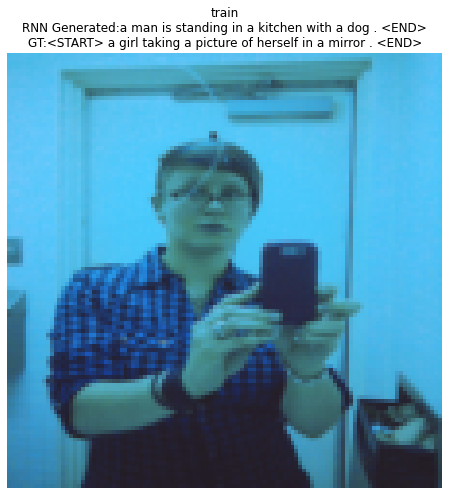

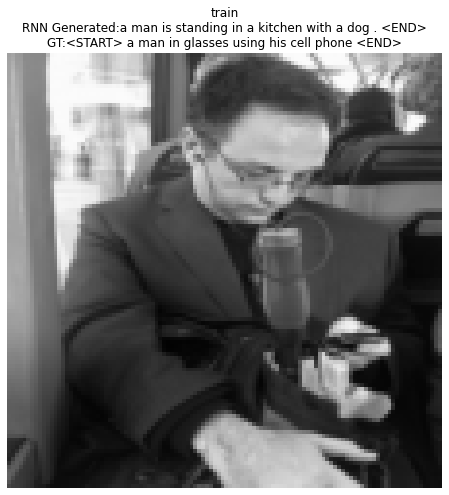

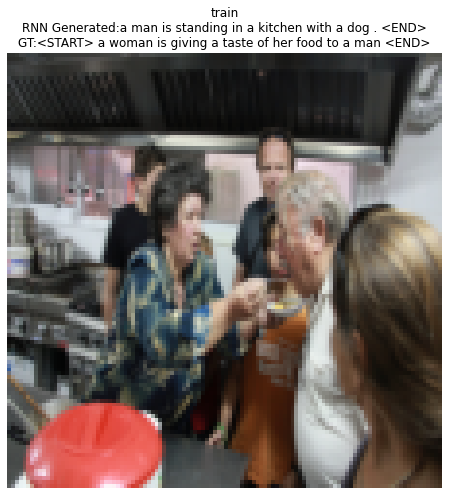

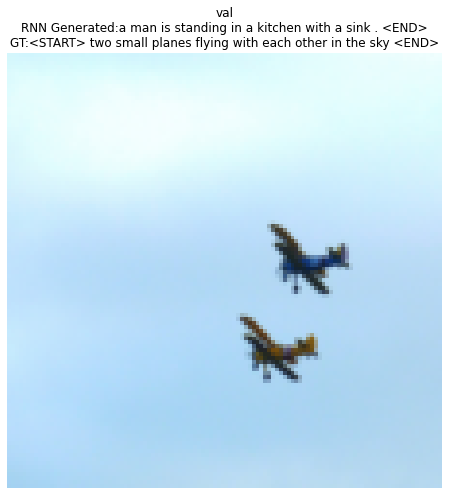

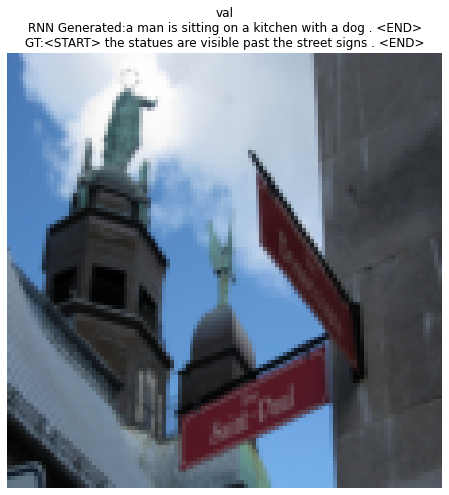

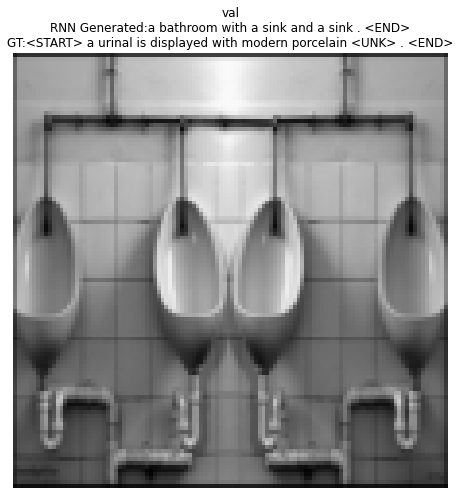

In [92]:
batch_size = 3

data_loader_train = torch.utils.data.DataLoader(dataset=coco_dataset_train, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              collate_fn=collate_fn)

data_loader_validation = torch.utils.data.DataLoader(dataset=coco_dataset_validation, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              collate_fn=collate_fn)

for split in ['train', 'val']:
  sample_images, sample_captions = [], []
  if split == "train":
    for j, (images, captions) in enumerate(data_loader_train):
      sample_images, sample_captions = images, captions
      break
  else:
    for j, (images, captions) in enumerate(data_loader_validation):
      sample_images, sample_captions = images, captions
      break
  
  gt_captions = decode_captions(sample_captions, idx_to_token)
  rnn_model.eval()
  generated_captions = rnn_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, idx_to_token)

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nRNN Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()

#LSTM

##Training the model

learning rate is:  0.001
(Epoch 0 / 5) loss: 58.7023 time per epoch: 96.5s
(Epoch 1 / 5) loss: 53.1604 time per epoch: 97.2s
(Epoch 2 / 5) loss: 46.4042 time per epoch: 97.1s
(Epoch 3 / 5) loss: 44.6739 time per epoch: 95.8s
(Epoch 4 / 5) loss: 44.2362 time per epoch: 94.3s


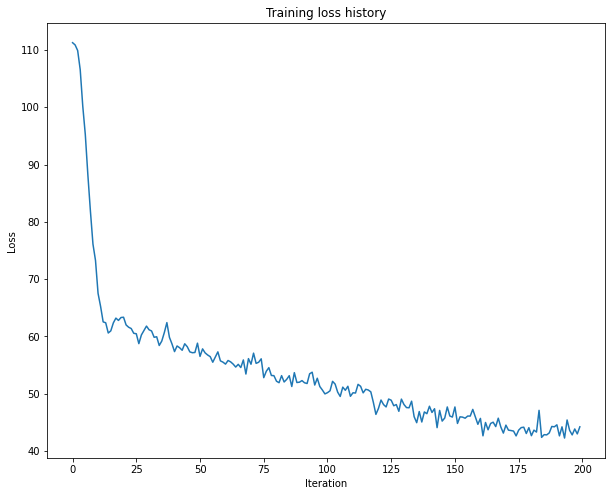

In [93]:
reset_seed(0)

# data input
small_num_train = num_train
batch_size = 250
shuffle = True

data_loader_train = torch.utils.data.DataLoader(dataset=coco_dataset_train, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              collate_fn=collate_fn)
# optimization arguments
num_epochs = 5

# create the image captioning model
lstm_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=token_to_idx,
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  lstm_model_submit, lstm_loss_submit = captioning_train(lstm_model, data_loader_train,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

##Testing the model

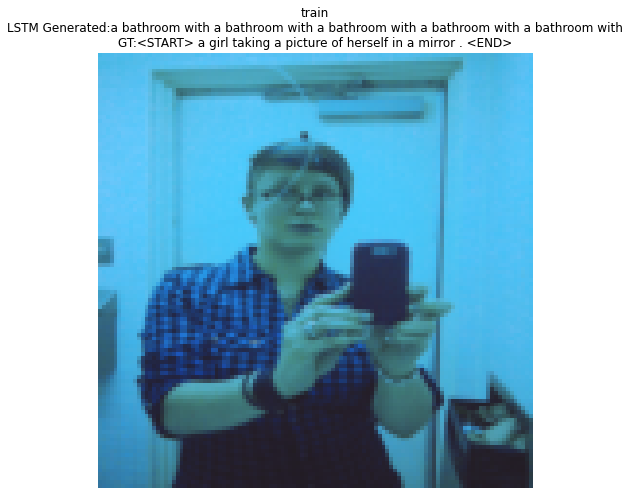

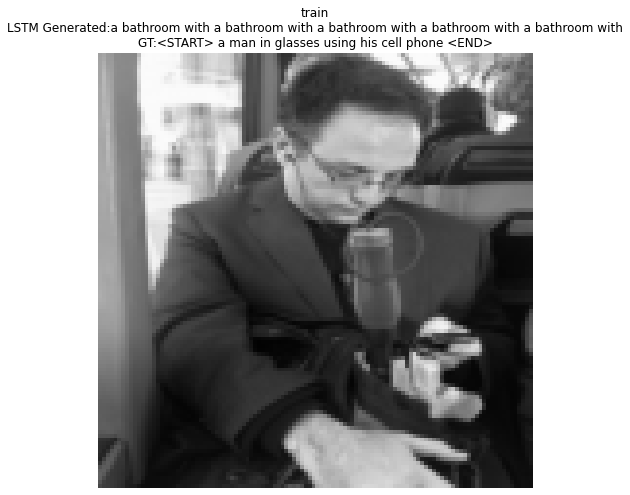

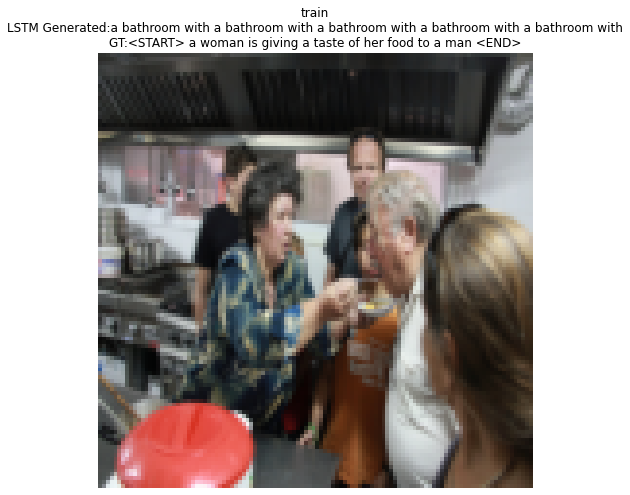

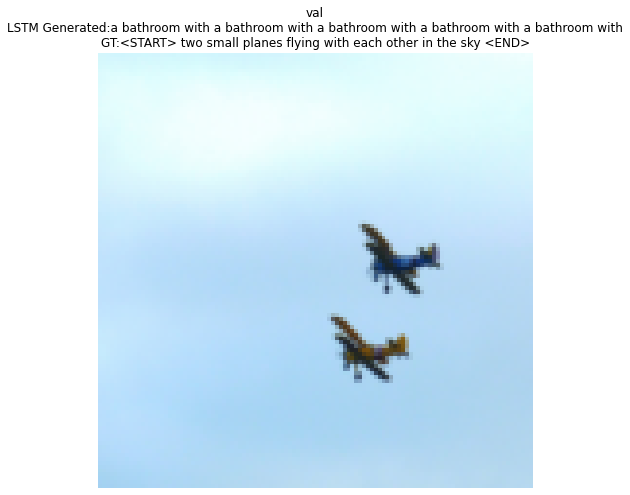

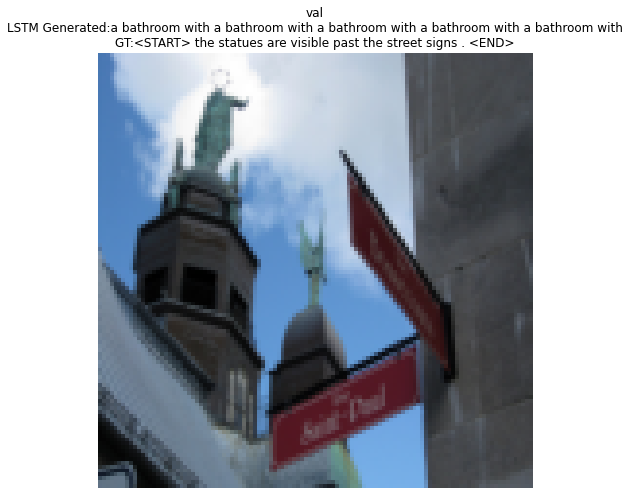

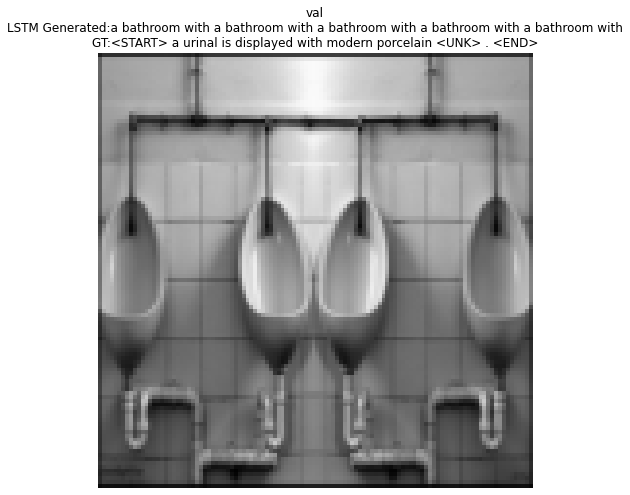

In [95]:
batch_size = 3

data_loader_train = torch.utils.data.DataLoader(dataset=coco_dataset_train, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              collate_fn=collate_fn)

data_loader_validation = torch.utils.data.DataLoader(dataset=coco_dataset_validation, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              collate_fn=collate_fn)

for split in ['train', 'val']:
  sample_images, sample_captions = [], []
  if split == "train":
    for j, (images, captions) in enumerate(data_loader_train):
      sample_images, sample_captions = images, captions
      break
  else:
    for j, (images, captions) in enumerate(data_loader_validation):
      sample_images, sample_captions = images, captions
      break
  # decode_captions is loaded from a4_helper.py
  gt_captions = decode_captions(sample_captions, idx_to_token)
  lstm_model.eval()
  generated_captions = lstm_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, idx_to_token)

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nLSTM Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()

#Attention LSTM

##Training the model

learning rate is:  0.001
(Epoch 0 / 5) loss: 58.4435 time per epoch: 97.5s
(Epoch 1 / 5) loss: 55.8576 time per epoch: 97.8s
(Epoch 2 / 5) loss: 52.1747 time per epoch: 97.4s
(Epoch 3 / 5) loss: 52.3396 time per epoch: 96.5s
(Epoch 4 / 5) loss: 52.2085 time per epoch: 97.7s


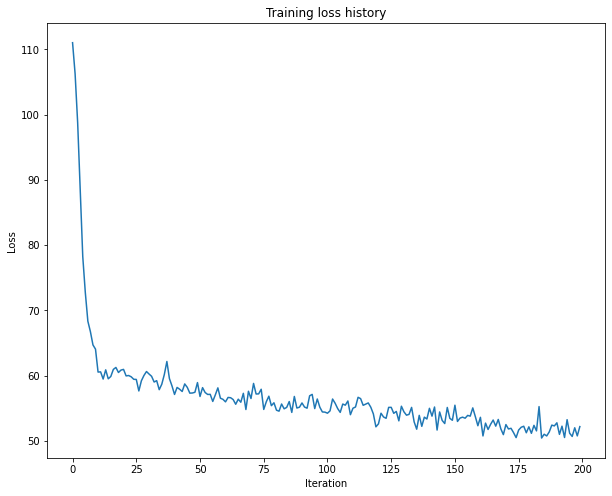

In [94]:
reset_seed(0)

# data input
small_num_train = num_train
batch_size = 250
shuffle = True

data_loader_train = torch.utils.data.DataLoader(dataset=coco_dataset_train, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              collate_fn=collate_fn)
# optimization arguments
num_epochs = 5

# create the image captioning model
attn_model = CaptioningRNN(
          cell_type='attention',
          word_to_idx=token_to_idx,
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  attn_model_submit, attn_loss_submit = captioning_train(attn_model, data_loader_train,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

##Testing the model

In [96]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by your model.

batch_size = 3
from torchvision.utils import make_grid
from torchvision import transforms

data_loader_train = torch.utils.data.DataLoader(dataset=coco_dataset_train, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              collate_fn=collate_fn)

data_loader_validation = torch.utils.data.DataLoader(dataset=coco_dataset_validation, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              collate_fn=collate_fn)

for split in ['train', 'val']:
  sample_images, sample_captions = [], []
  if split == "train":
    for j, (images, captions) in enumerate(data_loader_train):
      sample_images, sample_captions = images, captions
      break
  else:
    for j, (images, captions) in enumerate(data_loader_validation):
      sample_images, sample_captions = images, captions
      break
  # decode_captions is loaded from a4_helper.py
  gt_captions = decode_captions(sample_captions, idx_to_token)
  attn_model.eval()
  generated_captions, attn_weights_all = attn_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, idx_to_token)
  sample_images = sample_images.to("cpu")

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nAttention LSTM Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()
    
    tokens = generated_captions[i].split(' ')
    
    vis_attn = []
    for j in range(len(tokens)):
      img = sample_images[i]
      attn_weights = attn_weights_all[i][j]
      token = tokens[j]
      img_copy = attention_visualizer(img, attn_weights, token)
      vis_attn.append(transforms.ToTensor()(img_copy))
    
    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    vis_attn = make_grid(vis_attn, nrow=8)
    plt.imshow(torch.flip(vis_attn, dims=(0,)).permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    plt.rcParams['figure.figsize'] = (10.0, 8.0)

Output hidden; open in https://colab.research.google.com to view.